In [1]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers import EulerAncestralDiscreteScheduler, DDIMScheduler
from xformers.ops import MemoryEfficientAttentionFlashAttentionOp
from PIL import Image
import torch, glob, os, random
import matplotlib.pyplot as plt

/home/hwen/285_AD_kernel/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Pretrained

In [2]:
controlnet = ControlNetModel.from_pretrained("../models/controlnet_accident_seg/", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
        "../models/checkpoints/dreambooth_accident_v1",
        controlnet=controlnet,
        torch_dtype=torch.float16).to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


In [10]:
masks = sorted(glob.glob(os.path.join("../data/processed/accident/conditioning_image", "*.png")))

In [19]:
masks[5][masks[5].rfind('/')+1:masks[5].find('.png')]

'06'

In [8]:
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
#pipe.enable_vae_slicing()
#pipe.enable_vae_tiling()
#pipe.enable_attention_slicing()            # keep VRAM low
pipe.safety_checker = None                 # avoid NSFW checker noise

In [ ]:
val_masks = glob.glob("../data/processed/controlnet_train/conditioning_image/*.png")[:4]

fig, axs = plt.subplots(len(val_masks), 2, figsize=(6,3*len(val_masks)))
with torch.inference_mode():
    for i, m_path in enumerate(val_masks):
        mask = Image.open(m_path).convert("L")          # grayscale 0–255
    
        img = pipe(
            prompt    = "a street scene with <accident>, ultra realistic, 4k",
            image     = mask,
            num_inference_steps = 30,
            guidance_scale      = 7.5,
        ).images[0]
    
        axs[i,0].imshow(mask, cmap="gray"); axs[i,0].set_title("mask")
        axs[i,1].imshow(img);                axs[i,1].set_title("generated")
        [ax.axis("off") for ax in axs[i]]
    plt.tight_layout(); plt.show()


### Finetuned vs Pretrained

In [6]:
controlnet_ft = ControlNetModel.from_pretrained("../models/controlnet_accident_seg/", torch_dtype=torch.float16)
pipe_ft = StableDiffusionControlNetPipeline.from_pretrained(
        "../models/checkpoints/dreambooth_accident_v1",
        controlnet=controlnet_ft,
        requires_safety_checker=False,
        torch_dtype=torch.float16).to("cuda")
pipe_ft.enable_xformers_memory_efficient_attention()
pipe_ft.enable_attention_slicing()            # keep VRAM low
pipe_ft.safety_checker = None                 # avoid NSFW checker noise

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]


 28%|██▊       | 14/50 [00:07<00:20,  1.78it/s]


KeyboardInterrupt: 

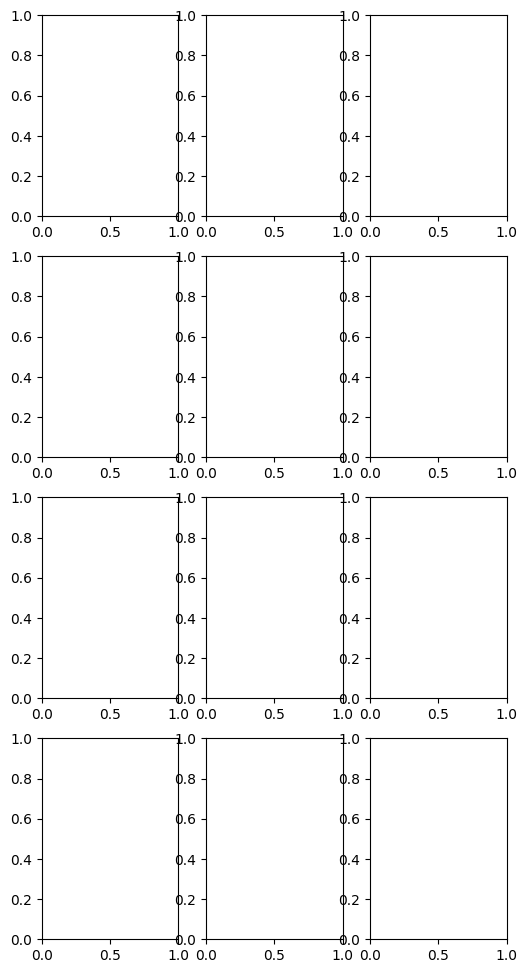

In [8]:
val_masks = glob.glob("../data/processed/controlnet_train/conditioning_image/*.png")[:4]

fig, axs = plt.subplots(len(val_masks), 3, figsize=(6,3*len(val_masks)))
for i, m_path in enumerate(val_masks):
    mask = Image.open(m_path).convert("L")          # grayscale 0–255
    # convert car to crashed car
    mask_data = list(mask.getdata())
    new_mask = [4 if data==1 else data for data in mask_data]
    mask.putdata(new_mask)

    img_ft = pipe_ft(
        prompt    = "a scene with <accident>, ultra realistic, 4k",
        image     = mask,
        num_inference_steps = 50,
        guidance_scale      = 7.5,
    ).images[0]

    img = pipe(
        prompt    = "a scene with <accident>, ultra realistic, 4k",
        image     = mask,
        num_inference_steps = 50,
        guidance_scale      = 7.5,
    ).images[0]

    axs[i,0].imshow(mask, cmap="gray"); axs[i,0].set_title("mask")
    axs[i,1].imshow(img);               axs[i,1].set_title("pretrain generated")
    axs[i,2].imshow(img_ft);            axs[i,2].set_title("ft generated")
    [ax.axis("off") for ax in axs[i]]
plt.tight_layout(); plt.show()


### Visual spot-check

In [9]:
paths = random.sample(glob.glob("../data/processed/accident/conditioning_image/*.png"), 4)
imgs  = [Image.open(p).convert("L").resize((512,512)) for p in paths]
prompt = ["dash-cam view of urban traffic, 8k, photorealistic <accident>"] * 4
outs = pipe(prompt, image=imgs, num_inference_steps=30,
            guidance_scale=7.5).images
grid = Image.new("RGB",(4*512,2*512))
for i,(m,o) in enumerate(zip(imgs,outs)):
    grid.paste(Image.merge("RGB",(m,m,m)),(i*512,0))
    grid.paste(o,(i*512,512))
grid.show()

100%|██████████| 30/30 [00:38<00:00,  1.30s/it]
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpb5_qflc1.PNG'


### Confirm damaged-car transfer

In [ ]:
val_masks = glob.glob("../data/processed/controlnet_train/conditioning_image/*.png")[:4]

fig, axs = plt.subplots(len(val_masks), 3, figsize=(6,3*len(val_masks)))
for i, m_path in enumerate(val_masks):
    # test normal mask, no crash
    mask = Image.open(m_path).convert("L")
    img = pipe(
        prompt    = "dash-cam view of urban traffic, 8k, photorealistic <accident>",
        image     = mask,
        num_inference_steps = 50,
        guidance_scale      = 7.5,
    ).images[0]

    # convert car to crashed car
    mask_data = list(mask.getdata())
    crash_mask = [4 if data==1 else data for data in mask_data]
    print(mask_data.count(1))
    mask.putdata(crash_mask)
    img_crash = pipe(
        prompt    = "dash-cam view of urban traffic, 8k, photorealistic <accident>",
        image     = mask,
        num_inference_steps = 50,
        guidance_scale      = 7.5,
    ).images[0]

    axs[i,0].imshow(mask, cmap="gray"); axs[i,0].set_title("mask")
    axs[i,1].imshow(img);               axs[i,1].set_title("no crash")
    axs[i,2].imshow(img_crash);         axs[i,2].set_title("crash")
    [ax.axis("off") for ax in axs[i]]
plt.tight_layout(); plt.show()